In [26]:
import rasterio
import matplotlib.pyplot as plt

lu2023 = 'data/lu2023_pred3.tif'
lu2018= 'data/lu2018_pred3.tif'
inundation = 'data/inundation/inundation_threshold_10m.tif'

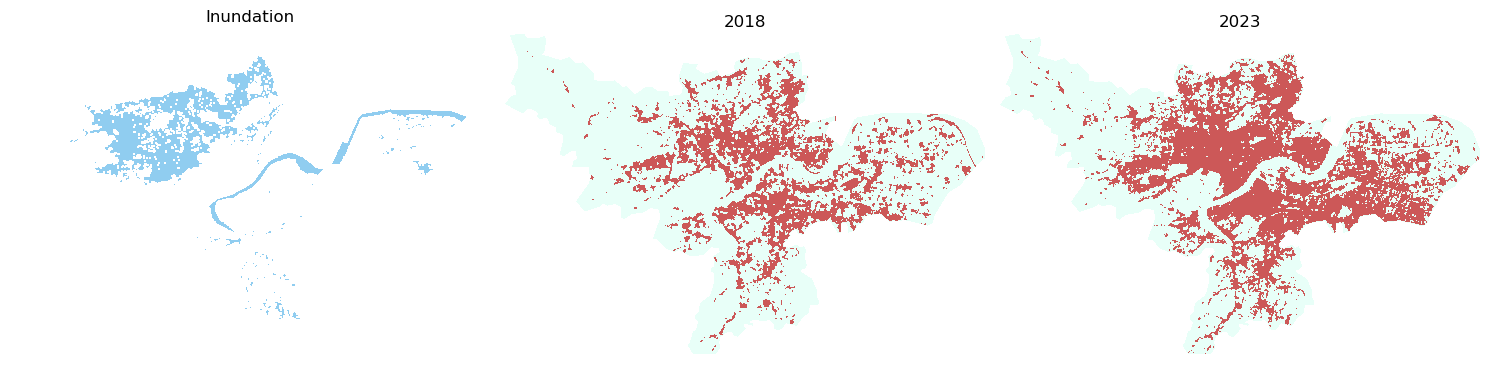

In [27]:
from matplotlib.colors import ListedColormap, BoundaryNorm

files = [inundation, lu2018, lu2023]
images = []

for file in files:
    with rasterio.open(file) as src:
        image = src.read(1) 
        images.append(image)

inundation_cmap = ListedColormap(['white', '#90cdf0'])  # 白色（0），蓝色（1）
inundation_norm = BoundaryNorm([0, 0.5, 1], inundation_cmap.N)

landcover_cmap = ListedColormap(['white', '#e8fff8', '#cc5858'])  # 白、浅绿、深红
landcover_norm = BoundaryNorm([0, 0.5, 1.5, 2], landcover_cmap.N)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, img, title in zip(axes, images, ['Inundation', '2018', '2023']):
    if title == 'Inundation':
        ax.imshow(img, cmap=inundation_cmap, norm=inundation_norm)
    else:
        ax.imshow(img, cmap=landcover_cmap, norm=landcover_norm)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [28]:
import rasterio
import rasterio.io
import geopandas as gpd
import numpy as np
from rasterio.enums import Resampling
from rasterio.mask import mask

def crop_and_save_raster(input_path, output_path, boundary_geom, resample=False, target_transform=None, target_shape=None, process_inundation=False):
    with rasterio.open(input_path) as src:
        if resample and target_shape and target_transform:
            # 需要重采样
            data = src.read(
                out_shape=(src.count, target_shape[0], target_shape[1]),
                resampling=Resampling.nearest
            )
            new_transform = target_transform
            new_crs = src.crs

            # 保存整个重采样后的大图到内存，再裁剪
            profile = src.profile
            profile.update({
                'transform': new_transform,
                'height': target_shape[0],
                'width': target_shape[1]
            })

            # 用重采样后的 data 临时生成一个 MemoryFile
            with rasterio.io.MemoryFile() as memfile:
                with memfile.open(**profile) as tmp_dataset:
                    tmp_dataset.write(data)
                    out_image, out_transform = mask(tmp_dataset, [boundary_geom], crop=True)
        else:
            # 不需要重采样
            data = src.read()
            out_image, out_transform = mask(src, [boundary_geom], crop=True)

        out_image = out_image[0]  # 只保存第一波段

        # 处理inundation数据
        if process_inundation:
            # 处理 NaN 为 0，转换为 uint8 类型
            out_image_clean = np.nan_to_num(out_image, nan=0)
            out_image_uint8 = out_image_clean.astype(np.uint8)
        else:
            out_image_uint8 = out_image

        # 保存裁剪结果
        with rasterio.open(output_path, 'w', driver='GTiff', count=1, dtype='uint8',
                           width=out_image_uint8.shape[1], height=out_image_uint8.shape[0],
                           crs=src.crs, transform=out_transform) as dst:
            dst.write(out_image_uint8, 1)

        print(f"文件已保存: {output_path}")
        with rasterio.open(output_path) as dst_check:
            print(dst_check.meta)
            print("=" * 40)

# 读取边界
boundary_shapefile = gpd.read_file('data/HZ_Center.shp')
boundary_geom = boundary_shapefile.geometry.unary_union

# 读取目标分辨率信息（lu2023）
with rasterio.open('data/lu2023_pred3.tif') as src_lu:
    lu_transform = src_lu.transform
    lu_crs = src_lu.crs
    target_shape = (src_lu.height, src_lu.width)

# 执行裁剪和保存
crop_and_save_raster('data/inundation/inundation_threshold_10m.tif', 'data/final_inundation.tif',
                     boundary_geom, resample=True, target_transform=lu_transform, target_shape=target_shape, process_inundation=True)

crop_and_save_raster('data/lu2023_pred3.tif', 'data/final_lu2023.tif',
                     boundary_geom, resample=False)

crop_and_save_raster('data/lu2018_pred3.tif', 'data/final_lu2018.tif',
                     boundary_geom, resample=False)

文件已保存: data/final_inundation.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 10752, 'height': 7168, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.691861210537235e-05, 0.0, 119.67717537043791,
       0.0, -9.691861210537235e-05, 30.565122687774874)}
文件已保存: data/final_lu2023.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 10752, 'height': 7168, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.691861210537235e-05, 0.0, 119.67717537043791,
       0.0, -9.691861210537235e-05, 30.565122687774874)}
文件已保存: data/final_lu2018.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 10752, 'height': 7168, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.691861210537235e-05, 0.0, 119.67717537043791,
       0.0, -9.691861210537235e-05, 30.565122687774874)}


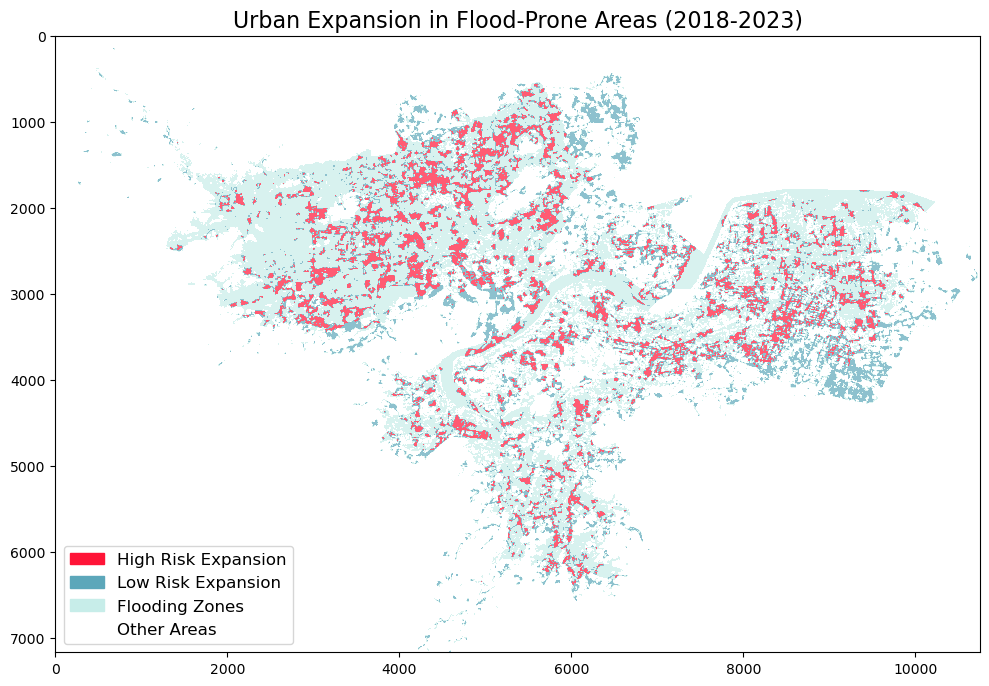

In [29]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import os  # 导入 os 模块

save_path ='png/urban_expansion_flood_prone_areas.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

inund = 'data/final_inundation.tif'
lu2023 = 'data/final_lu2023.tif' 
lu2018 = 'data/final_lu2018.tif' 

with rasterio.open(inund) as src:
    inund = src.read(1) 

with rasterio.open(lu2023) as src:
    lu2023 = src.read(1)

with rasterio.open(lu2018) as src:
    lu2018 = src.read(1)

lu2023 = np.where(lu2023 == 2, 1, 0)
lu2018 = np.where(lu2018 == 2, 1, 0)
lu_diff = lu2023 - lu2018

flood_risk = (inund > 0).astype(int)

high_risk_expansion = ((lu_diff > 0) & (flood_risk == 1)).astype(int)
low_risk_expansion = ((lu_diff > 0) & (flood_risk == 0)).astype(int)
other_area = ((lu_diff <= 0) & (flood_risk == 0)) 
flooding_no_expansion = ((lu_diff <= 0) & (flood_risk == 1)).astype(int)

combined_map = np.zeros_like(lu_diff, dtype=int)

combined_map[high_risk_expansion == 1] = 1 
combined_map[low_risk_expansion == 1] = 2
combined_map[flooding_no_expansion == 1] = 3 
combined_map[other_area] = 4               

cmap = ListedColormap(['#ff1437', '#5ca7ba', '#c7ede9', 'white']) 

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(combined_map, cmap=cmap, alpha=0.7)

ax.set_title('Urban Expansion in Flood-Prone Areas (2018-2023)', fontsize=16)

legend_handles = [
    mpatches.Patch(color='#ff1437', label='High Risk Expansion'),
    mpatches.Patch(color='#5ca7ba', label='Low Risk Expansion'),
    mpatches.Patch(color='#c7ede9', label='Flooding Zones'),
    mpatches.Patch(color='white', label='Other Areas')
]

ax.legend(handles=legend_handles, loc='lower left', fontsize=12)

# 保存图像到本地
plt.tight_layout()
plt.savefig(save_path, dpi=300)  # 保存为高分辨率PNG图像
plt.show()


In [42]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

with rasterio.open('data/final_lu2018.tif') as src2018:
    lu2018_data = src2018.read(1)
    transform = src2018.transform
    crs = src2018.crs
    bounds = src2018.bounds
    res_x, res_y = src2018.res

with rasterio.open('data/final_lu2023.tif') as src2023:
    lu2023_data = src2023.read(1)

with rasterio.open('data/final_inundation.tif') as src_inund:
    inundation_data = src_inund.read(1)

# hex_size
target_cols = 150
width_pixels = lu2018_data.shape[1]
hex_size_pixels = width_pixels / (1.5 * target_cols)
hex_size = hex_size_pixels * res_x

# 创建六边形网格
def create_hex_grid(bounds, hex_size):
    xmin, ymin, xmax, ymax = bounds
    width = hex_size * 2
    height = np.sqrt(3) * hex_size
    cols = int((xmax - xmin) / (width * 0.75)) + 2
    rows = int((ymax - ymin) / height) + 2

    hexagons = []
    for col in range(cols):
        for row in range(rows):
            x = xmin + col * width * 0.75
            y = ymin + row * height
            if col % 2 == 1:
                y += height / 2
            hexagon = Polygon([
                (x + hex_size * np.cos(np.radians(angle)),
                 y + hex_size * np.sin(np.radians(angle)))
                for angle in range(0, 360, 60)
            ])
            hexagons.append(hexagon)

    return gpd.GeoDataFrame(geometry=hexagons, crs=crs)

hex_grid = create_hex_grid(bounds, hex_size)


# 裁剪六边形
hex_grid = hex_grid.cx[bounds.left:bounds.right, bounds.bottom:bounds.top]

# 生成掩膜
mask_2018 = lu2018_data == 2
mask_2023 = lu2023_data == 2

percent_2018 = []
percent_2023 = []
inund_max = []
inund_mean = []

def coords_to_rowcol(transform, x, y):
    col, row = ~transform * (x, y)
    return int(row), int(col)

for hex in hex_grid.geometry:
    minx, miny, maxx, maxy = hex.bounds
    row_min, col_min = coords_to_rowcol(transform, minx, maxy)
    row_max, col_max = coords_to_rowcol(transform, maxx, miny)

    rows = np.arange(min(row_min, row_max), max(row_min, row_max) + 1)
    cols = np.arange(min(col_min, col_max), max(col_min, col_max) + 1)

    rows = np.clip(rows, 0, lu2018_data.shape[0] - 1)
    cols = np.clip(cols, 0, lu2018_data.shape[1] - 1)

    region_2018 = mask_2018[rows.min():rows.max()+1, cols.min():cols.max()+1]
    region_2023 = mask_2023[rows.min():rows.max()+1, cols.min():cols.max()+1]
    region_inund = inundation_data[rows.min():rows.max()+1, cols.min():cols.max()+1]

    total_pixels = region_2018.size
    pct2018 = np.sum(region_2018) / total_pixels
    pct2023 = np.sum(region_2023) / total_pixels
    inund_max_val = np.max(region_inund)
    inund_mean_val = np.mean(region_inund)

    percent_2018.append(pct2018)
    percent_2023.append(pct2023)
    inund_max.append(inund_max_val)
    inund_mean.append(inund_mean_val)


hex_grid['pct_2018'] = percent_2018
hex_grid['pct_2023'] = percent_2023
hex_grid['inund_max'] = inund_max
hex_grid['inund_mean'] = inund_mean


hex_grid.to_file('data/data.shp', driver='ESRI Shapefile', encoding='utf-8')

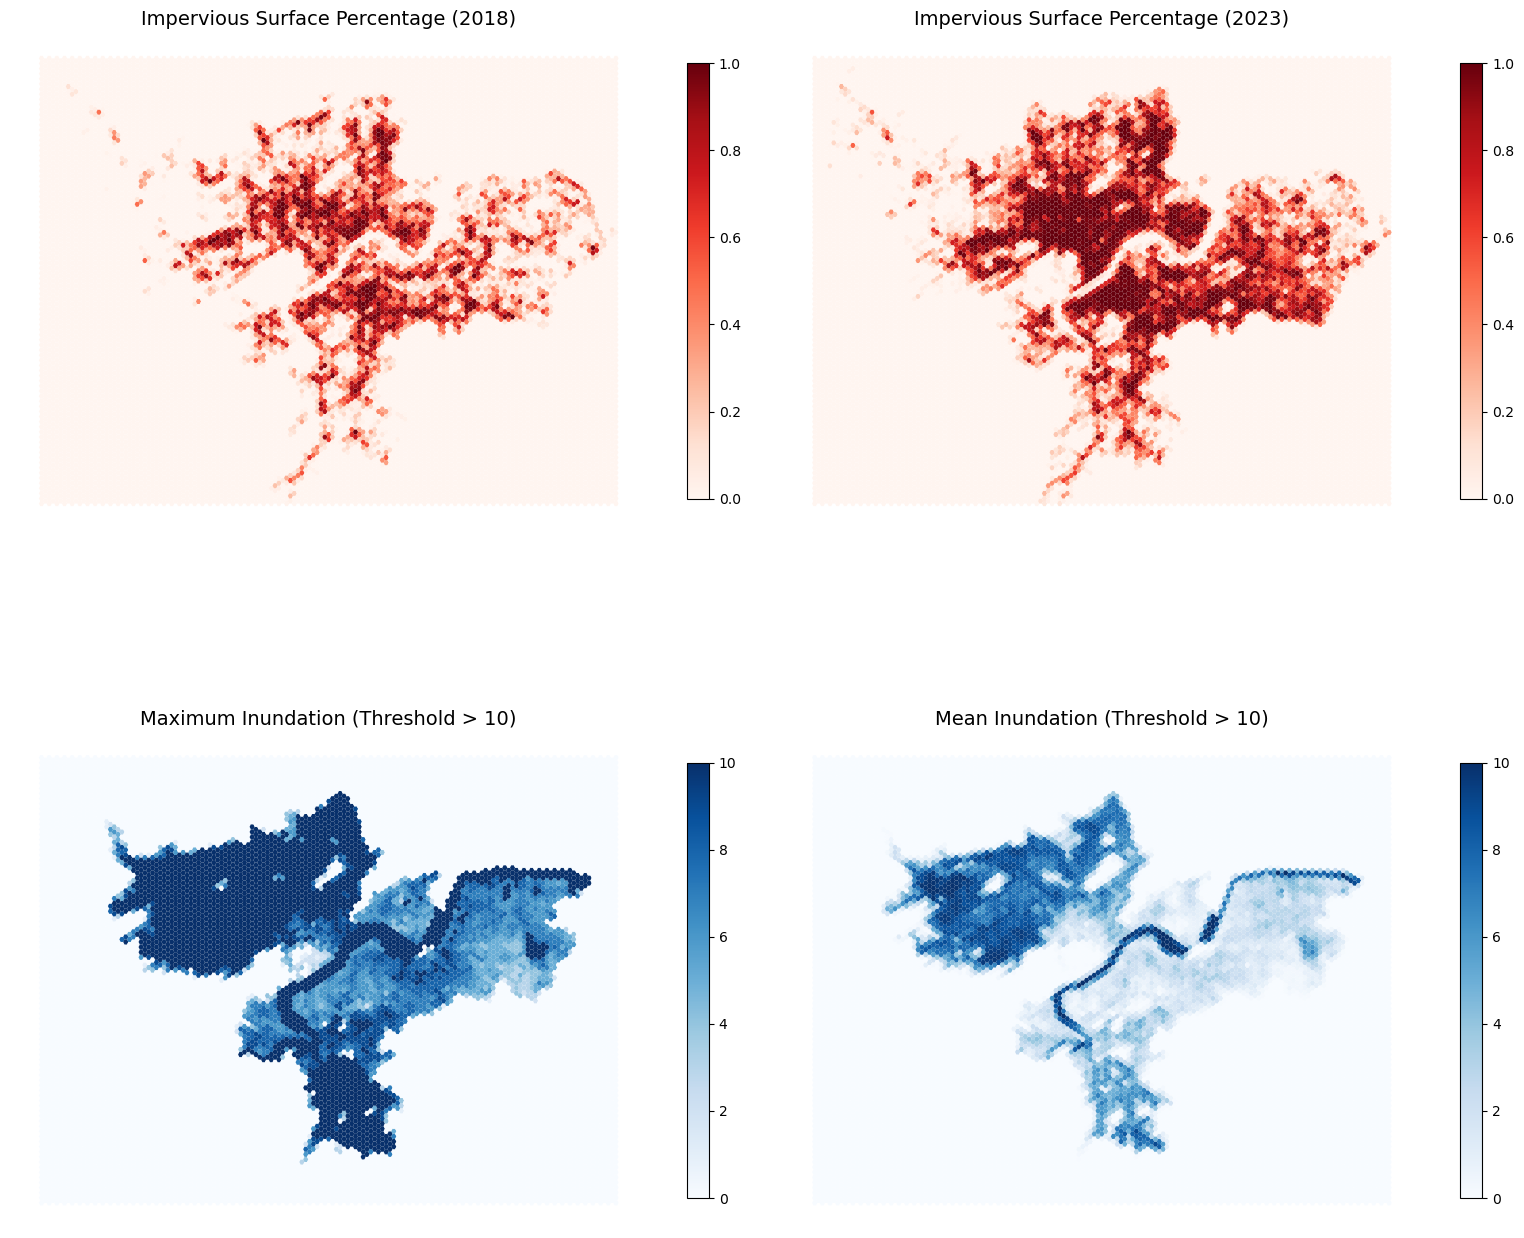

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt

hex_grid = gpd.read_file('data/data.shp')

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# 绘制不透水表面百分比（2018年）
ax1 = hex_grid.plot(column='pct_2018', cmap='Reds', legend=False, ax=axes[0, 0], 
                    legend_kwds={'shrink': 0.5})
axes[0, 0].set_title('Impervious Surface Percentage (2018)', fontsize=14)

# 绘制不透水表面百分比（2023年）
ax2 = hex_grid.plot(column='pct_2023', cmap='Reds', legend=False, ax=axes[0, 1], 
                    legend_kwds={'shrink': 0.5})
axes[0, 1].set_title('Impervious Surface Percentage (2023)', fontsize=14)

# 绘制最小淹水值（阈值 > 5）
ax3 = hex_grid.plot(column='inund_max', cmap='Blues', legend=False, ax=axes[1, 0], 
                    legend_kwds={'shrink': 0.5})
axes[1, 0].set_title('Maximum Inundation (Threshold > 10)', fontsize=14)

# 绘制平均淹水值（阈值 > 5）
ax4 = hex_grid.plot(column='inund_mean', cmap='Blues', legend=False, ax=axes[1, 1], 
                    legend_kwds={'shrink': 0.5})
axes[1, 1].set_title('Mean Inundation (Threshold > 10)', fontsize=14)

# 调整colorbar的字体大小
for ax in [ax1, ax2, ax3, ax4]:
    colorbar = ax.get_figure().colorbar(ax.collections[0], ax=ax, shrink=0.5)
    colorbar.ax.tick_params(labelsize=10)  # 修改colorbar字体大小

# 移除坐标轴
for ax in axes.flatten():
    ax.set_axis_off()

# 调整布局并显示
plt.tight_layout()
plt.show()

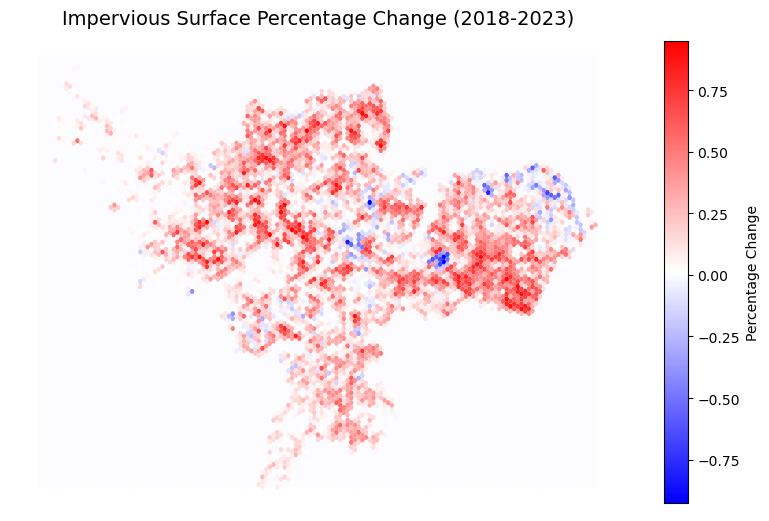

In [50]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

hex_grid = gpd.read_file('data/data.shp')

save_path ='png/Impervious_Surface_Percentage_Change.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

hex_grid['pct_diff'] = hex_grid['pct_2023'] - hex_grid['pct_2018']

colors = ['blue', 'white', 'red']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

fig, ax = plt.subplots(figsize=(8, 8))

hex_grid.plot(column='pct_diff', cmap=cmap, legend=True, ax=ax,
              legend_kwds={
                  'shrink': 0.6,
                  'label': "Percentage Change",
                  'orientation': 'vertical'
              })
ax.set_title('Impervious Surface Percentage Change (2018-2023)', fontsize=14)

ax.set_axis_off()
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

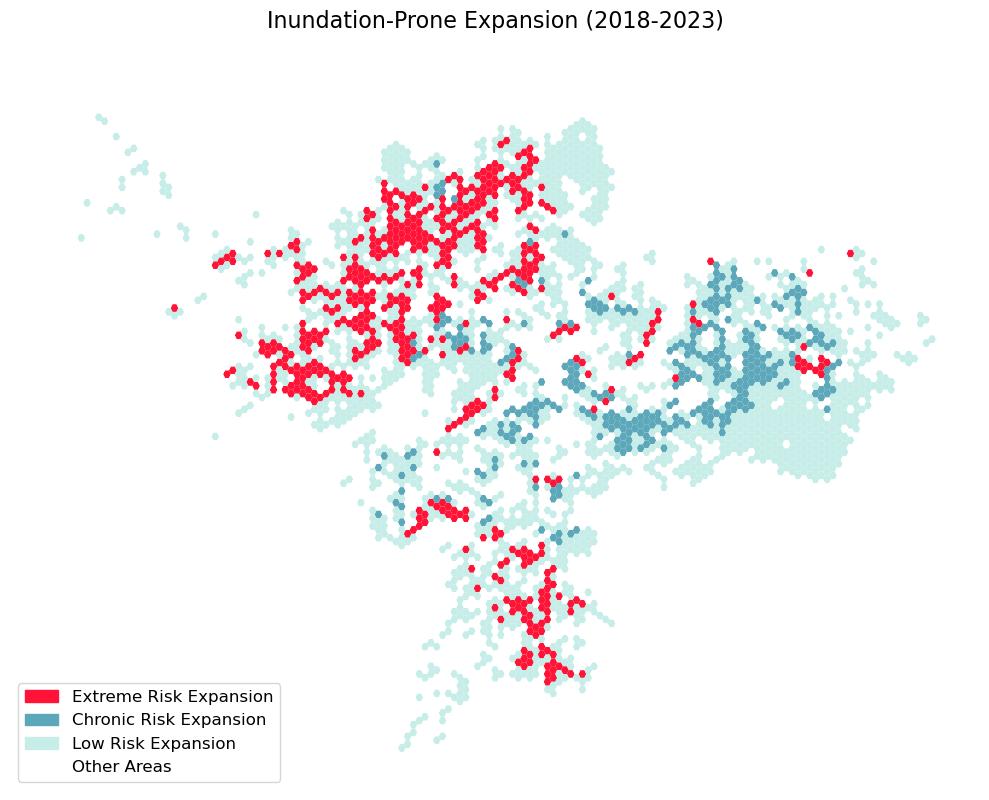

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# 读取数据
hex_grid = gpd.read_file('data/data.shp')

# 保存路径
save_path = 'png/urban_expansion_flood_prone_areas_grid.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 计算新增的不透水表面 pct_diff
hex_grid['pct_diff'] = hex_grid['pct_2023'] - hex_grid['pct_2018']

# 定义互斥分类（只属于一个类别）
hex_grid['risk_level'] = 'Other Areas'  # 默认其他区域

# 极端风险区域（优先级最高）
hex_grid.loc[
    (hex_grid['pct_diff'] > 0.3) & (hex_grid['inund_max'] > 9),
    'risk_level'
] = 'Extreme Risk Expansion'

# 慢性风险区域（次高优先级）
hex_grid.loc[
    (hex_grid['pct_diff'] > 0.3) & (hex_grid['inund_mean'] > 1) & (hex_grid['risk_level'] == 'Other Areas'),
    'risk_level'
] = 'Chronic Risk Expansion'

# 低风险区域（新增建成区但淹水风险低）
hex_grid.loc[
    (hex_grid['pct_diff'] > 0.1) & (hex_grid['risk_level'] == 'Other Areas'),
    'risk_level'
] = 'Low Risk Expansion'

# 颜色映射
color_map = {
    'Extreme Risk Expansion': '#ff1437', 
    'Chronic Risk Expansion': '#5ca7ba', 
    'Low Risk Expansion': '#c7ede9',     # 蓝色
    'Other Areas': 'white'           # 白色
}

# 绘制结果
fig, ax = plt.subplots(figsize=(10, 10))

# 按类别绘制
for risk_level, color in color_map.items():
    subset = hex_grid[hex_grid['risk_level'] == risk_level]
    subset.plot(ax=ax, color=color, alpha=1)

# 手动创建图例
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in color_map.items()
]

# 添加图例
ax.legend(handles=legend_handles, loc='lower left', fontsize=12)

# 设置标题
ax.set_title('Inundation-Prone Expansion (2018-2023)', fontsize=16)

# 关闭坐标轴
ax.set_axis_off()

# 美化布局
plt.tight_layout()

# 显示地图
plt.show()


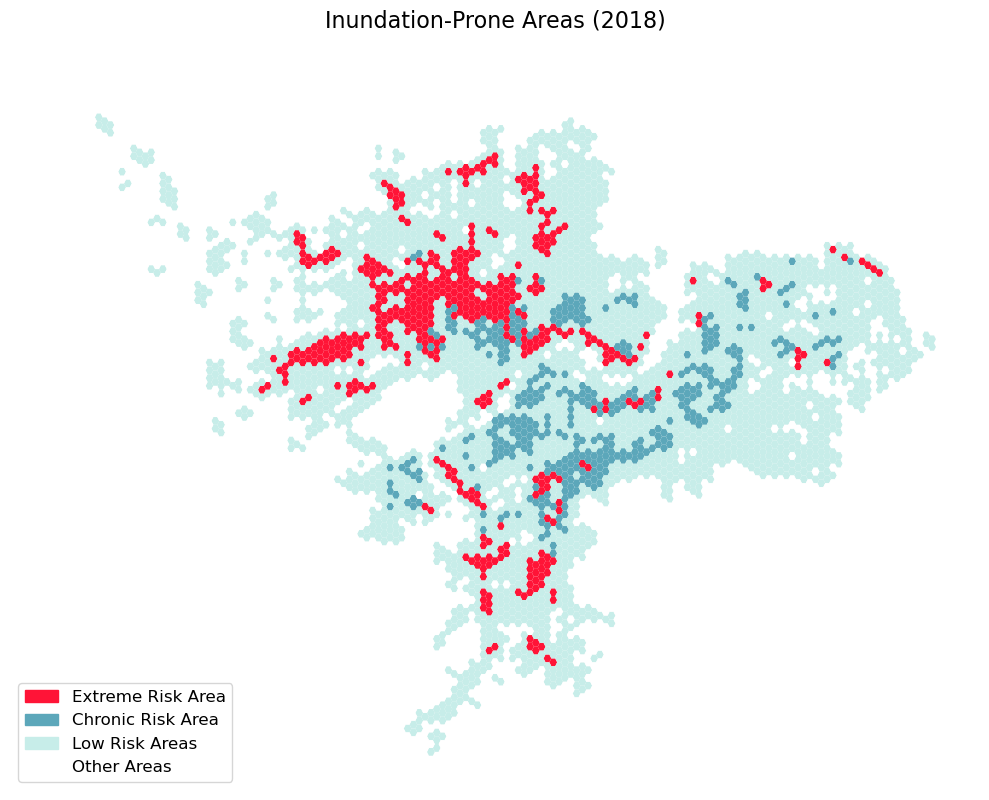

In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# 读取数据
hex_grid = gpd.read_file('data/data.shp')

# 保存路径
save_path = 'png/urban_expansion_flood_prone_areas_grid.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 计算新增的不透水表面 pct_diff
hex_grid['pct_diff'] = hex_grid['pct_2023'] - hex_grid['pct_2018']

# 定义互斥分类（只属于一个类别）
hex_grid['risk_level'] = 'Other Areas'  # 默认其他区域

# 极端风险区域（优先级最高）
hex_grid.loc[
    (hex_grid['pct_2018'] > 0.5) & (hex_grid['inund_max'] > 9),
    'risk_level'
] = 'Extreme Risk Area'

# 慢性风险区域（次高优先级）
hex_grid.loc[
    (hex_grid['pct_2018'] > 0.5) & (hex_grid['inund_mean'] > 1) & (hex_grid['risk_level'] == 'Other Areas'),
    'risk_level'
] = 'Chronic Risk Area'

# 低风险区域（新增建成区但淹水风险低）
hex_grid.loc[
    (hex_grid['pct_2018'] > 0) & (hex_grid['risk_level'] == 'Other Areas'),
    'risk_level'
] = 'Low Risk Areas'

# 颜色映射
color_map = {
    'Extreme Risk Area': '#ff1437', 
    'Chronic Risk Area': '#5ca7ba', 
    'Low Risk Areas': '#c7ede9',     # 蓝色
    'Other Areas': 'white'           # 白色
}

# 绘制结果
fig, ax = plt.subplots(figsize=(10, 10))

# 按类别绘制
for risk_level, color in color_map.items():
    subset = hex_grid[hex_grid['risk_level'] == risk_level]
    subset.plot(ax=ax, color=color, alpha=1)

# 手动创建图例
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in color_map.items()
]

# 添加图例
ax.legend(handles=legend_handles, loc='lower left', fontsize=12)

# 设置标题
ax.set_title('Inundation-Prone Areas (2018)', fontsize=16)

# 关闭坐标轴
ax.set_axis_off()

# 美化布局
plt.tight_layout()

# 显示地图
plt.show()


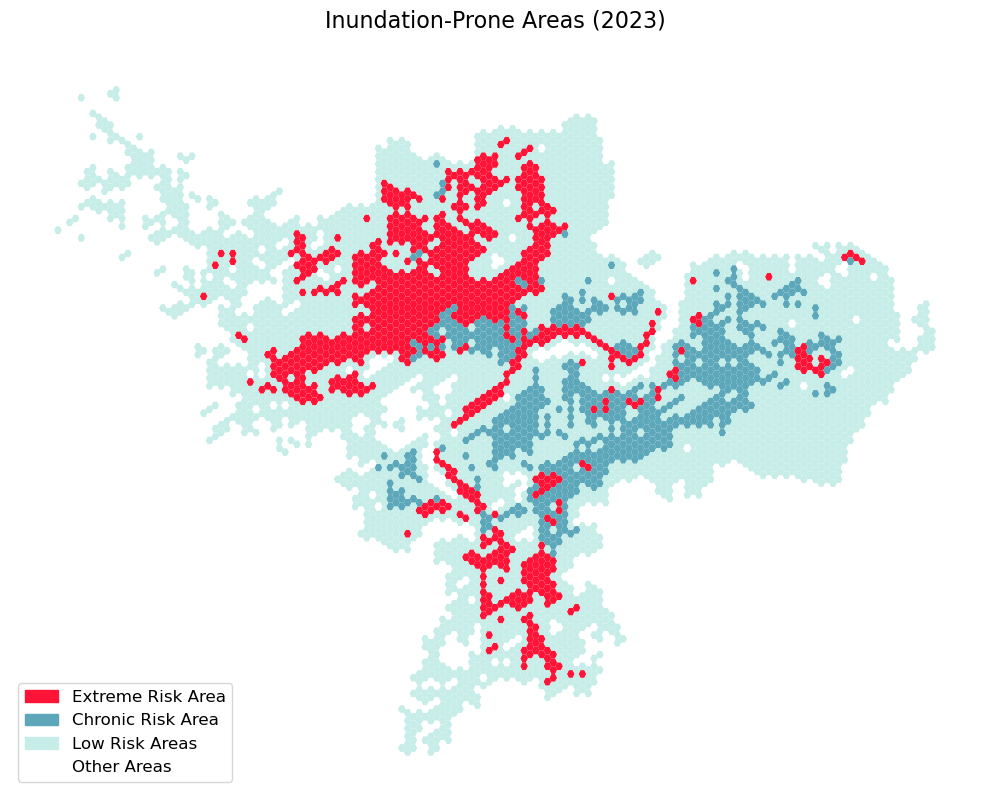

In [47]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# 读取数据
hex_grid = gpd.read_file('data/data.shp')

# 保存路径
save_path = 'png/urban_expansion_flood_prone_areas_grid.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 计算新增的不透水表面 pct_diff
hex_grid['pct_diff'] = hex_grid['pct_2023'] - hex_grid['pct_2018']

# 定义互斥分类（只属于一个类别）
hex_grid['risk_level'] = 'Other Areas'  # 默认其他区域

# 极端风险区域（优先级最高）
hex_grid.loc[
    (hex_grid['pct_2023'] > 0.5) & (hex_grid['inund_max'] > 9),
    'risk_level'
] = 'Extreme Risk Area'

# 慢性风险区域（次高优先级）
hex_grid.loc[
    (hex_grid['pct_2023'] > 0.5) & (hex_grid['inund_mean'] > 1) & (hex_grid['risk_level'] == 'Other Areas'),
    'risk_level'
] = 'Chronic Risk Area'

# 低风险区域（新增建成区但淹水风险低）
hex_grid.loc[
    (hex_grid['pct_2023'] > 0) & (hex_grid['risk_level'] == 'Other Areas'),
    'risk_level'
] = 'Low Risk Areas'

# 颜色映射
color_map = {
    'Extreme Risk Area': '#ff1437', 
    'Chronic Risk Area': '#5ca7ba', 
    'Low Risk Areas': '#c7ede9',     # 蓝色
    'Other Areas': 'white'           # 白色
}

# 绘制结果
fig, ax = plt.subplots(figsize=(10, 10))

# 按类别绘制
for risk_level, color in color_map.items():
    subset = hex_grid[hex_grid['risk_level'] == risk_level]
    subset.plot(ax=ax, color=color, alpha=1)

# 手动创建图例
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in color_map.items()
]

# 添加图例
ax.legend(handles=legend_handles, loc='lower left', fontsize=12)

# 设置标题
ax.set_title('Inundation-Prone Areas (2023)', fontsize=16)

# 关闭坐标轴
ax.set_axis_off()

# 美化布局
plt.tight_layout()

# 显示地图
plt.show()
